In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from moviepy.editor import VideoFileClip
from skimage import morphology
from collections import deque
from math import isnan
from pylab import *
%matplotlib inline
%matplotlib qt
get_ipython().run_line_magic('matplotlib', 'inline')


In [2]:
#转换灰度图像
def grayscale(img):
    return cv2.cvtColor(img , cv2.COLOR_RGB2GRAY)

#转换HLS图像
def hlsscale(img):
    return cv2.cvgColor(img , cv2.COLOR_RGB2HLS)

#照相机标定函数
def calibrate_camera():
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    objpoints = []
    imgpoints = []
    
    images = glob.glob('camera_cal/calibration*.jpg')
    
    #循环标定每张照片
    for fname in images:
        img = cv2.imread(fname)
        gray = grayscale(img)

        #查找棋盘角点
        ret , corners = cv2.findChessboardCorners(gray , (9,6) , None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    ret , mtx , dist , rvecs , tvecs = cv2.calibrateCamera(objpoints , imgpoints , gray.shape[::-1] , None , None)
    return mtx , dist


#畸变矫正函数
def undistort(img):
    mtx , dist = calibrate_camera()
    return cv2.undistort(img , mtx , dist , None , mtx)


#一维梯度处理函数
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gray = grayscale(img)

    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output

#二维梯度处理函数
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = grayscale(img)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 

    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return binary_output


#梯度方向处理函数
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = grayscale(img)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output

#hls颜色处理函数
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output


720 1280


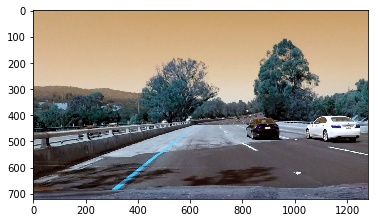

In [3]:
#图像载入区
#test_images/straight_lines1.jpg
#test_images/straight_lines2.jpg
#test_images/test1.jpg
#test_images/test2.jpg
#test_images/test3.jpg
#test_images/test4.jpg
#test_images/test5.jpg
#test_images/test6.jpg
#img = cv2.imread('test_images/straight_lines2.jpg')
img = cv2.imread('test_images/test4.jpg')
plt.imshow(img)
ysize = img.shape[0]
xsize = img.shape[1]
temp_img = np.copy(img)
print(ysize,xsize)



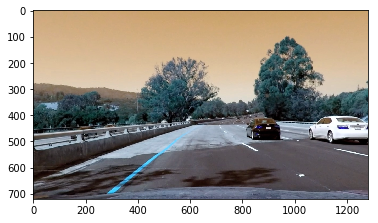

In [4]:

#畸变函数变换
img = undistort(img)
undist = np.copy(img)
plt.imshow(img)
#cv2.imwrite('camera_cal/result.jpg' , img)

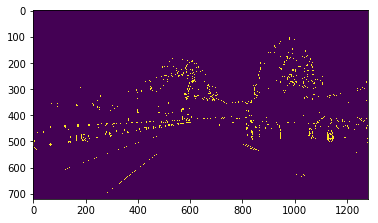

In [5]:
#sobel调试区
gradx = abs_sobel_thresh(img , 'x' , 50 , 255)
plt.imshow(gradx)
#grady = abs_sobel_thresh(img , 'y' , 40 , 250)

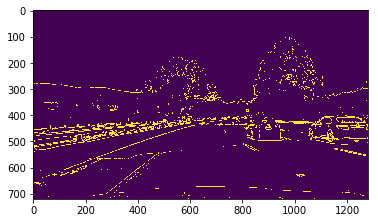

In [6]:
mag_binary = mag_thresh(img , 3 , (50 , 255))
plt.imshow(mag_binary)

In [7]:
#
#dir_binary = dir_threshold(img , 3 , (0.7 , 1.3))
#plt.imshow(dir_binary)

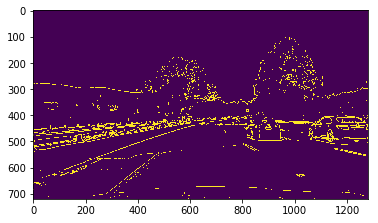

In [8]:
combined = np.zeros_like(gradx)
#combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
combined[(gradx == 1) | (mag_binary == 1)] = 1
plt.imshow(combined)

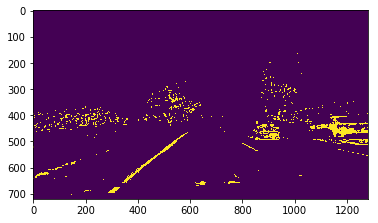

In [9]:
hls_binary = hls_select(img, thresh=(150, 255))
plt.imshow(hls_binary)

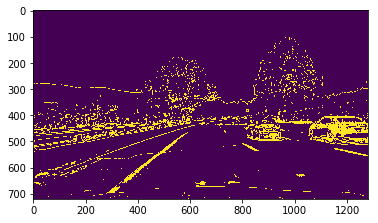

In [10]:
#
final_binary = np.zeros_like(hls_binary)
final_binary[(combined == 1) | (hls_binary == 1)] = 1
plt.imshow(final_binary)


In [11]:
#函数区
#区域选择函数
def region_of_interest(img, vertices):

    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

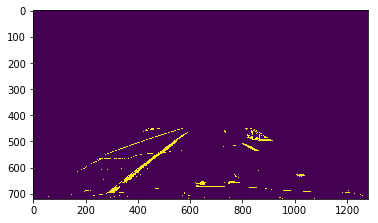

In [12]:

left_x_scale = 440/1280
right_x_scale = 840/1280
up_y_scale = 450/720
vertices = np.array([[(0,ysize) , (left_x_scale * xsize , up_y_scale * ysize) , (right_x_scale * xsize , up_y_scale * ysize) , (xsize,ysize)]] , dtype=np.int32)
masked_image = region_of_interest(final_binary , vertices)
plt.imshow(masked_image)

In [13]:
#函数区
#透视转换函数
def perspective(img , src , dst):
    M = cv2.getPerspectiveTransform(src , dst)
    Minv = cv2.getPerspectiveTransform(dst , src)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped , M , Minv

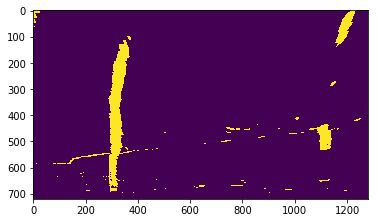

In [14]:
#选择四个点

src = np.float32([[244,686] , [581,459] , [704,459] , [1054,678]])
dst = np.float32([[244,686] , [244,0] , [1054,0] , [1054,678]])

#warped_img = perspective(temp_img , src , dst)
warped_img , M , Minv = perspective(masked_image , src , dst)
plt.imshow(warped_img)


In [15]:
#函数区
def hist(img):
    bottom_half = img[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    return histogram

#确认最终车道线的像素点
def find_lane_pixels(binary_warped):
    histogram = hist(binary_warped)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #计算车辆的中心位置
    center_position = (rightx_base - leftx_base) / 2 + leftx_base
    
    #滑动窗口参数
    nwindows = 9
    margin = 80
    minpix = 50
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        #标记window位置
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)   
        #plt.imshow(out_img)
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)    

        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))        

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]  
            
    return leftx, lefty, rightx, righty, out_img , center_position

#计算多项式拟合参数
def fit_polynomial(leftx , lefty , rightx , righty , out_img):
    #leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    ym_per_pix = 40/720
    xm_per_pix = 3.7/700
    
    left_fit_real = np.polyfit(lefty * ym_per_pix , leftx * xm_per_pix , 2)
    right_fit_real = np.polyfit(righty * ym_per_pix , rightx * xm_per_pix , 2)
    left_fit = np.polyfit(lefty , leftx , 2)
    right_fit = np.polyfit(righty , rightx , 2)

    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    plt.plot(left_fitx, ploty, color='blue')
    plt.plot(right_fitx, ploty, color='blue')

    return out_img , left_fit , right_fit , ploty , left_fitx , right_fitx , left_fit_real , right_fit_real


#计算曲率
def measure_curvature_pixels(left_fit , right_fit , ploty):
    #out_img , left_fit , right_fit , ploty = fit_polynomial(binary_warped)
    y_eval = np.max(ploty)

    ym_per_pix = 40/720
    xm_per_pix = 3.7/700
    
    #left_curverad_real = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    #right_curverad_real = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
     
    return left_curverad , right_curverad

In [16]:
#调试区
#histogram = hist(warped_img)
#plt.plot(histogram)
#print(measure_curvature_pixels(warped_img))
#leftx , lefty , rightx , righty , out_img = find_lane_pixels(warped_img)
#plt.imshow(out_img)

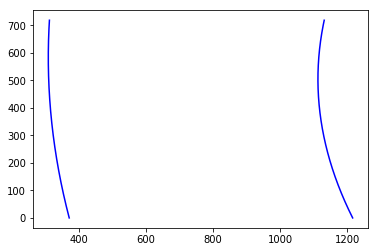

In [17]:

leftx , lefty , rightx , righty , out_img , center_position = find_lane_pixels(warped_img)
out_img , left_fit , right_fit , ploty , left_fitx , right_fitx , left_fit_real , right_fit_real = fit_polynomial(leftx , lefty , rightx , righty , out_img)
left_curverad , right_curverad = measure_curvature_pixels(left_fit , right_fit , ploty)
left_curverad_real , right_curverad_real = measure_curvature_pixels(left_fit_real , right_fit_real , ploty)


-0.3911428571428572
2055.295047947198 1920.5974213732463


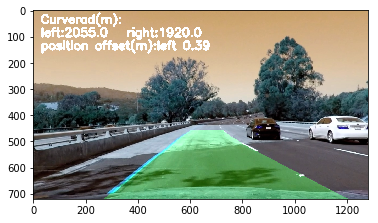

In [18]:


#画车道区域覆盖图
warp_zero = np.zeros_like(warped_img).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

newwarp = cv2.warpPerspective(color_warp, Minv, (xsize , ysize)) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
#plt.imshow(result)

xm_per_pix = 3.7/700
position_offset = (xsize / 2 - center_position) * xm_per_pix
print(position_offset)
print(left_curverad_real , right_curverad_real)

font=cv2.FONT_HERSHEY_SIMPLEX
s1 = 'Curverad(m):' 
s2 = 'left:' + str(left_curverad_real // 1) + '   ' + 'right:' + str(right_curverad_real // 1)
if position_offset < 0:
    left_or_right = 'left '
else:
    left_or_right = 'right '
s3 = 'position offset(m):' + left_or_right + str(round(abs(position_offset) , 2))
result=cv2.putText(result,s1,(30,50),font,1.5,(255,255,255),8)
result=cv2.putText(result,s2,(30,100),font,1.5,(255,255,255),8)
result=cv2.putText(result,s3,(30,150),font,1.5,(255,255,255),8)
plt.imshow(result)



In [19]:
def pipeline(img):
    ysize = img.shape[0]
    xsize = img.shape[1]
    
    #畸变矫正
    undist = undistort(img)
    #undist = np.copy(img)
    
    #车道像素识别
    gradx = abs_sobel_thresh(undist , 'x' , 50 , 255)
    mag_binary = mag_thresh(undist , 3 , (50 , 255))
    #combined = np.zeros_like(gradx)
    #combined[(gradx == 1) | (mag_binary == 1)] = 1
    hls_binary = hls_select(undist, thresh=(150, 255))
    final_binary = np.zeros_like(hls_binary)
    final_binary[(gradx == 1) | (mag_binary == 1) | (hls_binary == 1)] = 1
    
    #区域选择
    left_x_scale = 540/1280
    right_x_scale = 740/1280
    up_y_scale = 450/720
    vertices = np.array([[(0,ysize) , (left_x_scale * xsize , up_y_scale * ysize) , (right_x_scale * xsize , up_y_scale * ysize) , (xsize,ysize)]] , dtype=np.int32)
    masked_image = region_of_interest(final_binary , vertices)
    
    #透视变换
    src = np.float32([[244,686] , [581,459] , [704,459] , [1054,678]])
    dst = np.float32([[244,686] , [244,0] , [1054,0] , [1054,678]])
    warped_img , M , Minv = perspective(masked_image , src , dst)
    
    #曲率计算
    leftx, lefty, rightx, righty, out_img, center_position = find_lane_pixels(warped_img)
    out_img , left_fit , right_fit , ploty , left_fitx , right_fitx , left_fit_real , right_fit_real = fit_polynomial(leftx , lefty , rightx , righty , out_img)
    left_curverad, right_curverad = measure_curvature_pixels(left_fit , right_fit , ploty)
    left_curverad_real , right_curverad_real = measure_curvature_pixels(left_fit_real , right_fit_real , ploty)
    avg_curverad_real = (left_curverad_real + right_curverad_real) / 2

    #画车道区域覆盖图
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    newwarp = cv2.warpPerspective(color_warp, Minv, (xsize , ysize)) 
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    #图片上显示曲率和位置
    xm_per_pix = 3.7/700
    position_offset = (xsize / 2 - center_position) * xm_per_pix   #偏移中心的距离，单位：米

    font=cv2.FONT_HERSHEY_SIMPLEX
    s1 = 'Curverad(m):' 
    s2 = 'left:' + str(left_curverad_real // 1) + '   ' + 'right:' + str(right_curverad_real // 1)
    if position_offset < 0:
        left_or_right = 'left '
    else:
        left_or_right = 'right '
    s3 = 'position offset(m):' + left_or_right + str(round(abs(position_offset) , 2))
    result=cv2.putText(result,s1,(30,50),font,1.5,(255,255,255),8)
    result=cv2.putText(result,s2,(30,100),font,1.5,(255,255,255),8)
    result=cv2.putText(result,s3,(30,150),font,1.5,(255,255,255),8)
    plt.imshow(result)

       
    return result.astype('uint8')

In [20]:
#video_output = 'harder_challenge_solution.mp4'
#clipl = VideoFileClip("harder_challenge_video.mp4")
#white_clip = clipl.fl_image(pipeline)
#%time white_clip.write_videofile(video_output,audio=False)